# 10-Modeling
---

Brief Intro Here --- Performing RANDOM FOREST instead of Linear model analysis (like in the other notebook)

During initial testing (right now) we will focus on predicting the Abdominal Pain Index (API) -- `api_tot_recode0_4_post`

## Import Packages + Setup

In [6]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import pickle
import os

from pathlib import Path
from datetime import datetime

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# SKLEARN
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.impute import KNNImputer

from imblearn.over_sampling import RandomOverSampler

# stats models
import statsmodels.api as sm
from scipy import stats

# Printint output
from IPython.core.interactiveshell import InteractiveShell

# Define Functions
---

Here we are defining our functions that both perform the out-of-bootstrap sampling but also collect and save the results in a nice, friendly manner!

In [7]:
def rf_bootstrap(n, k, param_grid, seeds, target_field, pipe, 
                 target_data, X_data, samples=None, error = 'mae',
                 impute_knn = False):
    """
    n: Number of loops / iterations
    k: cross-folds
    seeds: list of seeds for resampling
    target_fields: target variable
    target_data: target data + other data (subgroup, treatment, etc)
    X_data: predictors

    Returns
    ----
    model_store: list. Best model from each iteration. Includes feature importance
    model_results: mae, var, median mae for each iteration.
    """
    pd.set_option('mode.chained_assignment',None)

    # Output Variables
    model_results = {
        'overall': {
            error : [],
            'median': [],
            'var': []
        },
        'study_group': {
            'CBT': {
                error : [],
                'median': [],
                'var': []
            },
            'EDU': {
                error : [],
                'median': [],
                'var': []
            }
        },
        'fap_subgroup': {
            'HPD': {
                error : [],
                'median': [],
                'var': []
            },
            'HPA': {
                error : [],
                'median': [],
                'var': []
            },
            'LPA': {
                error : [],
                'median': [],
                'var': []
            }
            
        }
    }

    model_store = []
    saved_predictions = pd.DataFrame()

    # MODEL LOOP
    # OUTER LOOOP - OOB BOOSTRAP
    for outer_loop in range(n):
        X_train, y_data = resample(X_data, target_data, replace = True, 
                                    n_samples = samples, random_state = seeds[outer_loop])
        
        y_train = y_data[target_field]
        
        # INNER LOOP - K-FOLD CV (GRID SEARCH)
        # Define socring based on metric
        if error == 'mae':
            scoring = 'neg_mean_absolute_error'
        else:
            scoring = 'neg_mean_squared_error'

        gs = RandomizedSearchCV(
                pipe, 
                param_distributions = param_grid, 
                cv = k,
                scoring=scoring, 
                n_jobs=-1)

        
        # Cross Validation Fit
        gs.fit(X_train, y_train)
        
        # store best model
        best_model = gs.best_estimator_.named_steps['clf']  # this is the same
        model_store.append(best_model)

        # Get best model params
        best_params = best_model.get_params()
        best_params['oob_score'] = True
        
        # fit full dataset
        # IMPUTE VALUES AS NEEDED
        if impute_knn:
            imputer = KNNImputer(n_neighbors=impute_knn)
            x_train_impute = imputer.fit_transform(X_train)

            X_train = pd.DataFrame(
                data = x_train_impute,
                columns = X_train.columns.values,
                index = X_train.index.values   
            )
            
        rf_best = RandomForestRegressor(**best_params)
        rf_best.fit(X_train, y_train)
        y_data['prediction'] = rf_best.oob_prediction_

        # Predictions added to df + save (`saved_predictions`)
        y_data[error] = abs(y_data[target_field] - y_data['prediction'])
        saved_predictions = pd.concat([saved_predictions, y_data])
        
        # STORE RESULTS
        tmp_overall = y_data[error].agg(['mean', 'median', 'var'])
        tmp_treatment = y_data[[error, 'study_group']].groupby('study_group').agg(['mean', 'median', 'var'])
        tmp_subgroup = y_data[[error, 'cluster2019_base']].groupby('cluster2019_base').agg(['mean', 'median', 'var'])

        
        # overall results
        model_results['overall'][error].append(tmp_overall['mean'])
        model_results['overall']['median'].append(tmp_overall['median'])
        model_results['overall']['var'].append(tmp_overall['var'])


        # Study Group (Treatment)
        model_results['study_group']['CBT'][error].append(tmp_treatment[error]['mean'][3])
        model_results['study_group']['CBT']['median'].append(tmp_treatment[error]['median'][3])
        model_results['study_group']['CBT']['var'].append(tmp_treatment[error]['var'][3])

        model_results['study_group']['EDU'][error].append(tmp_treatment[error]['mean'][1])
        model_results['study_group']['EDU']['median'].append(tmp_treatment[error]['median'][1])
        model_results['study_group']['EDU']['var'].append(tmp_treatment[error]['var'][1])


        # FAP Classification
        model_results['fap_subgroup']['HPD'][error].append(tmp_subgroup[error]['mean'][1])
        model_results['fap_subgroup']['HPD']['median'].append(tmp_subgroup[error]['median'][1])
        model_results['fap_subgroup']['HPD']['var'].append(tmp_subgroup[error]['var'][1])

        model_results['fap_subgroup']['HPA'][error].append(tmp_subgroup[error]['mean'][2])
        model_results['fap_subgroup']['HPA']['median'].append(tmp_subgroup[error]['median'][2])
        model_results['fap_subgroup']['HPA']['var'].append(tmp_subgroup[error]['var'][2])

        model_results['fap_subgroup']['LPA'][error].append(tmp_subgroup[error]['mean'][3])
        model_results['fap_subgroup']['LPA']['median'].append(tmp_subgroup[error]['median'][3])
        model_results['fap_subgroup']['LPA']['var'].append(tmp_subgroup[error]['var'][3])

    return model_store, model_results, saved_predictions


In [8]:
def regression_outer_loop(outcome_list, 
                     X_data,
                     target_df, 
                     sub_folder,
                     param_grid,
                     seeds,
                     knn_neighbors = 0):

    for target in outcome_list:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f'starting on: {target} --- {current_time}')

        # Get subset of target data!
        target_data = df_targets[[target, 'study_group', 'cluster2019_base']].copy()

        # Folder to save results
        save_folder = f'{sub_folder}/' + target

        if target == 'cprinterf8_delta':
            error = 'mse'
        else:
            error = 'mae'
        
        # Dont include knn in pipeline if we don't want it
        if knn_neighbors == 0:
            knn_neighbors = False
            pipe = Pipeline([
                ("clf", RandomForestRegressor(criterion=error)),
            ])
        else:
            pipe = Pipeline([
                ('knn_impute', KNNImputer(n_neighbors=knn_neighbors)),
                ("clf", RandomForestRegressor(criterion=error)),
            ])

        # run modeling
        model_store, model_results, preds = \
            rf_bootstrap(
                n = n, 
                k = k, 
                param_grid = param_grid, 
                seeds = seeds, 
                target_field = target, 
                target_data = target_data, 
                X_data = X_data,
                error = error,
                pipe = pipe,
                impute_knn = knn_neighbors)

        # SAVE DATA
        # ---------------------------

        # create folder if not exist
        Path(f'data/{save_folder}').mkdir(parents=True, exist_ok=True)

        # model store
        with open(f"../data/{save_folder}/model_store.pickle", "wb") as ms:
            pickle.dump(model_store, ms)

        # model results
        with open(f"../data/{save_folder}/model_results.txt", "wb") as mr:
            pickle.dump(model_results, mr)

        # predictions
        with open(f"../data/{save_folder}/predictions.txt", "wb") as pred:
            pickle.dump(preds, pred)

    return

# Iterative Random Forest
---

Loop through the following scenarios using our Random Forest code to iteratively whittle down the feature space. The results will be stored up one directory in a `data` folder (one will be created if it doesn't already exist).

The same code can be executed for any of the four (4) CSVs we created in `10-process-data.ipynb`. The cells below are only executed for non-scaled, no missing data as it performed the best. To use one of the other CSVs just change the CSV name in the improt data section below.

If you want to impute values using KNN - set the knn_neighbors parameter to anything != 0.

**Resources**

https://forums.fast.ai/t/oob-score-vs-validation-score/7859/6
<br>
https://stats.stackexchange.com/questions/300776/oob-score-vs-test-set-accuray-random-forest



## Import + Prep Data
---

In [9]:
# Import Data
# ---------------------
df = pd.read_csv("../data/cleaned/not_scaled_no_missing.csv")

# Example - Importing non-scaled with missing data
# df = pd.read_csv("data/cleaned/not_scaled_with_missing.csv")

In [10]:
# Setup our Target DataFrame. Drop Base/Post data from our prediction DF
# ---------------------
# Make adjustments to our DataFrames + Targets
df_targets = df[[
    'cluster2019_base', 'study_group',
    'api_tot_recode0_4_base', 'csigimn2019_base', 'cprinterf8_base', 'cprint8_tscore_base',
    'api_tot_recode0_4_post', 'csigimn2019_post', 'cprinterf8_post', 'cprint8_tscore_post',
    ]]

df = df.drop(
    ['api_tot_recode0_4_base', 'csigimn2019_base', 'cprinterf8_base', 'cprint8_tscore_base',
     'api_tot_recode0_4_post', 'csigimn2019_post', 'cprinterf8_post', 'cprint8_tscore_post'], 
    axis = 1
)

# Keep study group (treatment). Remove FAP Subgroup
df = df.drop('cluster2019_base', axis=1)

# Calculate our delta
df_targets['api_delta'] = df_targets['api_tot_recode0_4_post'] - df_targets['api_tot_recode0_4_base']
df_targets['csigi_delta'] = df_targets['csigimn2019_post'] - df_targets['csigimn2019_base']
df_targets['cprinterf8_delta'] = df_targets['cprinterf8_post'] - df_targets['cprinterf8_base']

# Split out target + dataframe
X_data = df.copy()

ipykernel_launcher:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Round Age of Conscent
---

In the source data, age of conscent is really specific (many decimal places). This gives that feature in particular a HUGE feature space in comparison to our questionairre responses and the difference between 10.12341 and 10.451231 years is probably not that significant.

Below we round the age to the nearest 0.5 years -- Rounding to the nearest year might make a significant difference due to how quickly kids grow


In [11]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def round_to_05(n):
    return round_to(n, 0.5)

In [12]:
X_data['age_consent'] = df['age_consent'].apply(lambda x: round_to_05(x))

## Part 1 - All Features
---

Out of Bootstrap RAndom Forest Regression using all the features in our data. This will be our random forest performance baseline.

### Model Parameters


In [ ]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0   # change here if you want to KNN impute missing values

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_delta', 'csigi_delta', 'cprinterf8_delta']

# SAVING FOLDER
sub_folder = 'outcome_delta/all_features'

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}


### Model Loop


In [ ]:
# ALL FEATURES
model_outer_loop(
    X_data = X_data,
    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 23:17:27
starting on: csigi_delta --- 23:29:22
starting on: cprinterf8_delta --- 23:41:33


## Part 2 -- Top X Features (10, 15, 20)
----

Instead of using all ~122 we are using the top 20 from each of our 3 outcome variables. Just based on average importance (and not best model), this gives us only 36 variables!!

To this we will add study_group (just to see).

The code from the previous loop will be copied but this time with only 3 loops - only MSE for PROMIS

In [ ]:
# Columns (Top 20 -- 46 total + study_group)!
# ---------------------
col_subset_20 = [
    'age_consent','api1_txfap','api2_txfap','api3_txfap','api4_txfap','cdi18_txfap',
    'csi10_txfap','csi11_txfap','csi12_txfap','csi13_txfap','csi14_txfap','csi15_txfap',
    'csi17_txfap','csi19_txfap','csi20_txfap','csi21_txfap','csi22_txfap','csi23_txfap',
    'csi3_txfap','csi4_txfap','csi6_txfap','csi8_txfap','fdi12_txfap','fdi13_txfap','fdi5_txfap',
    'fdi8_txfap','fdi9_txfap','pbq10_txfap','pbq12_txfap','pbq14_txfap','pbq15_txfap','pbq16_txfap',
    'pbq6_txfap','pbq8_txfap','pcsc11_txfap','pcsc12_txfap','pcsc7_txfap','pri11_txfap','pri15_txfap',
    'promis_anx4_txfap','promis_anx5_txfap','promis_anx7_txfap','prsleep3_txfap','prsleep4_txfap',
    'prsleep6_txfap','prsleep7_txfap'
]

col_subset_20.append('study_group')

# Get Data Subset
# ---------------------
X_data_subset_20 = X_data[col_subset_20]

In [ ]:
# Columns (Top 15 -- 38 total + study_group)!
# ---------------------
col_subset_15 = list({
 'api1_txfap', 'api2_txfap', 'api3_txfap', 'age_consent', 'fdi8_txfap', 
 'csi15_txfap', 'pbq16_txfap', 'api4_txfap', 'cdi18_txfap', 'csi8_txfap', 
 'pbq8_txfap', 'csi4_txfap', 'csi13_txfap', 'csi19_txfap', 'pbq6_txfap', 'csi13_txfap', 
 'csi21_txfap', 'csi12_txfap', 'csi15_txfap', 'api4_txfap', 'csi14_txfap', 'csi20_txfap', 
 'csi23_txfap', 'csi17_txfap', 'promis_anx5_txfap', 'csi3_txfap', 'pcsc7_txfap', 'age_consent', 
 'pbq14_txfap', 'csi22_txfap', 'fdi9_txfap', 'fdi12_txfap', 'fdi13_txfap', 'csi10_txfap', 
 'prsleep4_txfap', 'fdi5_txfap', 'pbq10_txfap', 'prsleep7_txfap', 'csi21_txfap', 'pbq12_txfap', 
 'csi13_txfap', 'csi23_txfap', 'promis_anx7_txfap', 'pcsc12_txfap', 'csi6_txfap'})

print(len(col_subset_15))

col_subset_15.append('study_group')

# Get Data Subset
# ---------------------
X_data_subset_15 = X_data[col_subset_15]

38


In [ ]:
# Columns (Top 10 -- 27 total + study_group)!
# ---------------------
col_subset_10 = list({
    'fdi9_txfap', 'fdi12_txfap', 'fdi13_txfap', 'csi10_txfap', 'prsleep4_txfap', 
    'fdi5_txfap', 'pbq10_txfap', 'prsleep7_txfap', 'csi21_txfap', 'pbq12_txfap', 
    'csi13_txfap', 'csi21_txfap', 'csi12_txfap', 'csi15_txfap', 'api4_txfap', 'csi14_txfap', 
    'csi20_txfap', 'csi23_txfap', 'csi17_txfap', 'promis_anx5_txfap', 'api1_txfap', 'api2_txfap', 
    'api3_txfap', 'age_consent', 'fdi8_txfap', 'csi15_txfap', 'pbq16_txfap', 'api4_txfap', 
    'cdi18_txfap', 'csi8_txfap'})

print(len(col_subset_10))

col_subset_10.append('study_group')

# Get Data Subset
# ---------------------
X_data_subset_10 = X_data[col_subset_10]

27


In [ ]:
for i in col_subset_10:
  print(i)

csi10_txfap
api2_txfap
api4_txfap
csi12_txfap
fdi9_txfap
prsleep4_txfap
csi14_txfap
csi13_txfap
csi17_txfap
pbq10_txfap
csi21_txfap
csi20_txfap
csi23_txfap
promis_anx5_txfap
api1_txfap
fdi5_txfap
cdi18_txfap
csi15_txfap
fdi8_txfap
prsleep7_txfap
csi8_txfap
fdi13_txfap
pbq12_txfap
age_consent
pbq16_txfap
fdi12_txfap
api3_txfap
study_group


### Model Parameters

In [ ]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_delta', 'csigi_delta', 'cprinterf8_delta']

# SAVING FOLDER
# sub_folder = 'outcome_delta/top_20_features'

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}


### Model Loops

In [ ]:
# TOP 20 FEATURES
sub_folder = 'outcome_delta/top_20_features'

model_outer_loop(
    X_data = X_data_subset_20,
    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 00:20:18
starting on: csigi_delta --- 00:26:55
starting on: cprinterf8_delta --- 00:33:40


In [ ]:
# TOP 15 FEATURES
sub_folder = 'outcome_delta/top_15_features'

model_outer_loop(
    X_data = X_data_subset_15,
    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 00:39:56
starting on: csigi_delta --- 00:46:14
starting on: cprinterf8_delta --- 00:52:24


In [ ]:
# TOP 10 FEATURES
sub_folder = 'outcome_delta/top_10_features'

model_outer_loop(
    X_data = X_data_subset_10,
    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 00:55:45
starting on: csigi_delta --- 01:00:49
starting on: cprinterf8_delta --- 01:06:14


## Part 3 - Top Model Features Only
---

In only picking the top columns across all our outcome variables, we have 49 features, with 50 total (+1 for study_group).

In [ ]:
# Columns!
# ---------------------
col_subset_top = [
  'pbq1_txfap', 'promis_anx4_txfap', 'csi21_txfap', 'csi1_txfap', 'csi10_txfap', 
  'promis_anx7_txfap', 'promis_anx6_txfap', 'pcsc10_txfap', 'csi3_txfap', 'csi5_txfap', 
  'api1_txfap', 'pcsc12_txfap', 'csi13_txfap', 'pbq8_txfap', 'pbq3_txfap', 'fdi3_txfap', 
  'cdi22_txfap', 'study_group', 'fdi8_txfap', 'csi12_txfap', 'prsleep4_txfap', 'pbq9_txfap', 
  'pbq10_txfap', 'prsleep3_txfap', 'api3_txfap', 'age_consent', 'pcsc5_txfap', 'cdi8_txfap', 
  'cdi16_txfap', 'cdi25_txfap', 'prsleep5_txfap', 'sex', 'pbq15_txfap', 'cdi10_txfap', 'promis_anx8_txfap', 
  'csi8_txfap', 'prsleep6_txfap', 'pcsc9_txfap', 'promis_anx5_txfap', 'cdi9_txfap', 'pcsc3_txfap', 'csi9_txfap', 
  'pbq17_txfap', 'fdi12_txfap', 'cdi23_txfap', 'pbq4_txfap', 'prsleep7_txfap', 'pbq7_txfap'
]

col_subset_top.append('study_group')

# Get Data Subset
# ---------------------
X_data_subset_top = X_data[col_subset_top]

### Model Parameters
---

In [ ]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_delta', 'csigi_delta', 'cprinterf8_delta']

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}

### Model Loop

In [ ]:
# TOP 20 FEATURES
sub_folder = 'outcome_delta/top_model_features_only'

model_outer_loop(
    X_data = X_data_subset_top,
    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 11:24:00
starting on: csigi_delta --- 11:30:50
starting on: cprinterf8_delta --- 11:37:33


## Part 4 - Random Features
---

Becaues we're seeing a stabilization of MSE/MAE for each out of outcome variables, wanting to do a quick sanity on if selecting features at random makes a significant impact

In [ ]:
# Columns!
# ---------------------
np.random.seed(2021)
rand_col_index = np.random.randint(
    low = 0,
    high = 120, 
    size = 40)

X_data_subset_random = X_data.iloc[:, rand_col_index] 

### Model Parameters

In [ ]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_delta', 'csigi_delta', 'cprinterf8_delta']

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}

### Model Loop

In [ ]:
# RANDOM FEATURES
sub_folder = 'outcome_delta/random_features'

model_outer_loop(
    
    # - EDIT DATA HERE ----------
    X_data = X_data_subset_random,
    # ---------------------------

    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 11:46:38
starting on: csigi_delta --- 11:52:51
starting on: cprinterf8_delta --- 11:59:03


## Part 5 - Mutual Information Regression
---

Top 15 from each outcome variable from mutual information regression (38 total)

In [ ]:
col_subset_mir = [
 'csi15_txfap', 'csi16_txfap', 'api3_txfap', 'api1_txfap', 
 'api2_txfap', 'pbq2_txfap', 'cdi22_txfap', 'pcsc12_txfap', 'promis_anx1_txfap', 
 'pcsc5_txfap', 'cdi12_txfap', 'promis_anx3_txfap', 'pcsc9_txfap', 'pcsc10_txfap', 
 'csi7_txfap', 'pbq5_txfap', 'csi21_txfap', 'pcsc11_txfap', 'promis_anx7_txfap', 'fdi8_txfap', 
 'prsleep4_txfap', 'csi14_txfap', 'promis_anx2_txfap', 'prsleep1_txfap', 'cdi8_txfap', 
 'csi17_txfap', 'csi9_txfap', 'cdi7_txfap', 'promis_anx8_txfap', 'pcsc8_txfap', 'pbq3_txfap', 
 'pbq4_txfap', 'csi2_txfap', 'fdi12_txfap', 'pbq8_txfap', 'fdi9_txfap', 'pcsc3_txfap', 'pbq12_txfap'
]

# Get Data Subset
# ---------------------
X_data_subset_mir = X_data[col_subset_mir]

### Model Parameters

In [ ]:
# MODEL SETUP
n = 50              # OUTER LOOP ITERATIONS (down from 100)
k = 3               # cross-folds
knn_neighbors = 0

seeds = np.random.randint(10000, size = n)

# Looping through targets
outcomes = ['api_delta', 'csigi_delta', 'cprinterf8_delta']

# Parameter grid
param_grid = {
    "clf__n_estimators": [50, 80, 100, 120, 150],
    "clf__max_depth": [3, 4, 5, 6, 10],
    "clf__max_features": [*np.arange(0.10, 0.80, 0.05)],
    "clf__min_samples_split": [3, 5, 10, 15, 20, 40, 50],
    "clf__min_samples_leaf": [2, 3, 4, 5] # guarantees a min number of samples in every leaf
}

### Model Loop

In [ ]:
# RANDOM FEATURES
sub_folder = 'outcome_delta/mir_15'

model_outer_loop(
    
    # - EDIT DATA HERE ----------
    X_data = X_data_subset_mir,
    # ---------------------------

    target_df = df_targets,
    outcome_list = outcomes,
    sub_folder = sub_folder,
    param_grid = param_grid,
    seeds = seeds,
    knn_neighbors = knn_neighbors)

starting on: api_delta --- 12:11:43
starting on: csigi_delta --- 12:17:50
starting on: cprinterf8_delta --- 12:23:42


## Part 6 - Classification!
---

Jacobson Clinical Signifiance / Reliable Change Index [link]()

Calcuate it two ways. Varying definintions on how to calculate. Chronbach Alpha scores were provided
* RCI 1 -- https://lbecker.uccs.edu/clinsig
* RCI 2 -- https://www.psyctc.org/stats/rcsc1.htm

In [202]:
with open(f'data/{sub_folder}/api_rci_1/predictions.txt', 'rb') as tmp:
    df_predictions = pickle.load(tmp)

In [203]:
threshold = 0.5

# Prediction stored is if = 0 (not changed). So we need to take the reverse of our evaluation
df_predictions['prediction'] = ~(df_predictions['predict_not_changed'] >= threshold)
df_predictions['is_predict_correct'] = df_predictions['api_rci_1'] == df_predictions['prediction']


In [204]:
# AVERAGE ACCURACY
df_predictions['is_predict_correct'].sum() / df_predictions.shape[0]

0.8440217391304348

In [207]:
# Accuracy by Cluster

print('Cluster 1 - High Pain Dysfunctional')
df_subgroup = df_predictions.loc[df_predictions['cluster2019_base'] == 1]
num_correct = df_subgroup['is_predict_correct'].sum()

accuracy = num_correct / df_subgroup.shape[0]
precision = precision_score(df_subgroup['api_rci_1'], df_subgroup['prediction'])
recall = recall_score(df_subgroup['api_rci_1'], df_subgroup['prediction'])

print(f'Accuracy: {round(accuracy,3)}')
print(f'Precision: {round(precision,3)}')
print(f'Recall: {round(recall,3)}')

print()

print('Cluster 2 - High Pain Adaptive')
df_subgroup = df_predictions.loc[df_predictions['cluster2019_base'] == 2]
num_correct = df_subgroup['is_predict_correct'].sum()

accuracy = num_correct / df_subgroup.shape[0]
precision = precision_score(df_subgroup['api_rci_1'], df_subgroup['prediction'])
recall = recall_score(df_subgroup['api_rci_1'], df_subgroup['prediction'])

print(f'Accuracy: {round(accuracy,3)}')
print(f'Precision: {round(precision,3)}')
print(f'Recall: {round(recall,3)}')

print()

print('Cluster 3 - Low Pain Adaptive')
df_subgroup = df_predictions.loc[df_predictions['cluster2019_base'] == 3]
num_correct = df_subgroup['is_predict_correct'].sum()

accuracy = num_correct / df_subgroup.shape[0]
precision = precision_score(df_subgroup['api_rci_1'], df_subgroup['prediction'])
recall = recall_score(df_subgroup['api_rci_1'], df_subgroup['prediction'])

print(f'Accuracy: {round(accuracy,3)}')
print(f'Precision: {round(precision,3)}')
print(f'Recall: {round(recall,3)}')

Cluster 1 - High Pain Dysfunctional
Accuracy: 0.818
Precision: 0.851
Recall: 0.667

Cluster 2 - High Pain Adaptive
Accuracy: 0.852
Precision: 0.917
Recall: 0.574

Cluster 3 - Low Pain Adaptive
Accuracy: 0.875
Precision: 0.931
Recall: 0.54


In [190]:
from sklearn.metrics import recall_score, precision_score, plot_roc_curve

In [189]:
precision_score(hpd_predictions['api_rci_1'], hpd_predictions['prediction'])

0.8506787330316742

## Evaluations (Re-used Across Loops)
---

1. Report MSE/MAE (Overall average, variance, best result). Create a table showing error by FAP Subgroup (row) and Treatment (Column), including totals
Goal of this is to show if there's been any bias / poor results for a class
2. MAE / MSE distributions (Overall, Study Group, Treatment)
3. Top X Features (15?)
4. Top 20 models - what were the parameters. How did they compare?

In [ ]:
# LOAD SAVED DATA

# include subfolder!
# ['api_delta', 'csigi_delta', 'cprinterf8_delta']

outcome_var = 'cprinterf8_delta'
sub_folder='outcome_delta/mir_15'
folder = f'{sub_folder}/{outcome_var}'

with open(f'data/{folder}/model_store.pickle', 'rb') as tmp:
    model_store = pickle.load(tmp)

with open(f'data/{folder}/model_results.txt', 'rb') as tmp:
    model_results = pickle.load(tmp)

with open(f'data/{folder}/predictions.txt', 'rb') as tmp:
    predictions = pickle.load(tmp)

In [ ]:
# General info (min/max/mean error and index)
# ---------------------------

print('Best Model Error, Index')
print(round(min(model_results['overall']['mae']), 4))
print(model_results['overall']['mae'].index(min(model_results['overall']['mae'])))

print('')
print('Worst Model Error, Index')
print(round(max(model_results['overall']['mae']), 4))
print(model_results['overall']['mae'].index(max(model_results['overall']['mae'])))

print('')
print(np.array(model_results['overall']['mae']).mean().round(4))
print(np.array(model_results['overall']['mae']).var().round(4))

Best Model Error, Index
2.789
16

Worst Model Error, Index
4.2691
28

3.7092
0.0877


In [ ]:
# Average Error by Combination
# ---------------------------

predictions[['study_group', 'cluster2019_base', 'mae']]\
  .groupby(['study_group', 'cluster2019_base'])\
  .mean()\
  .reset_index()

,study_group,cluster2019_base,mae
0,1,1,5.559887
1,1,2,3.198477
2,1,3,1.683557
3,3,1,4.527698
4,3,2,3.821655
5,3,3,1.816898


In [ ]:
# Average Error by Combination
# ---------------------------

predictions[['cluster2019_base', 'mae']]\
  .groupby(['cluster2019_base'])\
  .mean()\
  .reset_index()

,cluster2019_base,mae
0,1,5.003570
1,2,3.476736
2,3,1.751562


In [ ]:
# Overall Error/Variance by SG/Subgroup
# ---------------------------
print(f"HPD: {predictions.loc[predictions.cluster2019_base == 1]['mae'].mean()}")
print(f"HPA: {predictions.loc[predictions.cluster2019_base == 2]['mae'].mean()}")
print(f"LPA: {predictions.loc[predictions.cluster2019_base == 3]['mae'].mean()}")

print()
print(f"EDU: {predictions.loc[predictions.study_group == 1]['mae'].mean()}")
print(f"CBT: {predictions.loc[predictions.study_group == 3]['mae'].mean()}")

HPD: 5.0035698159235515
HPA: 3.4767362789901872
LPA: 1.7515616163339751

EDU: 3.7201863097371586
CBT: 3.697992116635559


### Visualizations
---

In [ ]:
# Prep data to graph Results
df_treatment_mae = pd.melt(pd.DataFrame({
    'CBT': model_results['study_group']['CBT']['mae'],
    'EDU': model_results['study_group']['EDU']['mae']
}))

df_subgroup_mae = pd.melt(pd.DataFrame({
    'HPD': model_results['fap_subgroup']['HPD']['mae'],
    'HPA': model_results['fap_subgroup']['HPA']['mae'],
    'LPA': model_results['fap_subgroup']['LPA']['mae']
}))

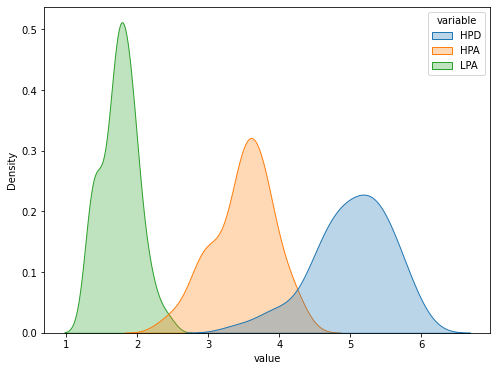

In [ ]:
# ERROR by subgroup
# ---------------------------
rcParams['figure.figsize'] = 8,6

fig = sns.kdeplot(
    # data=df_treatment_mae,
    data=df_subgroup_mae,
    x='value',
    hue='variable',
    shade=True,
    alpha=.3,
);

# plt.xlabel('MAE');

# plt.savefig('api_delta_error')

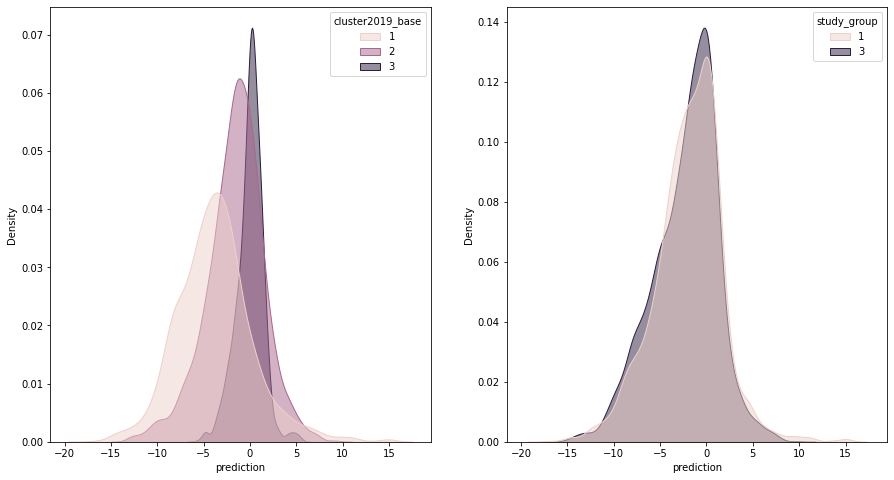

In [ ]:
# Distribution of Predictions
# ---------------------------
rcParams['figure.figsize'] = 15, 8
fig, ax = plt.subplots(1,2, sharex=True)

sns.kdeplot(
    data=predictions,
    x='prediction',
    shade=True,
    alpha=.5,
    hue = 'cluster2019_base',
    common_norm = True,
    ax=ax[0]
);

sns.kdeplot(
    data=predictions,
    x='prediction',
    shade=True,
    alpha=.5,
    hue='study_group',
    common_norm = False,
    ax=ax[1]
);


# plt.savefig('api_delta_prediction')

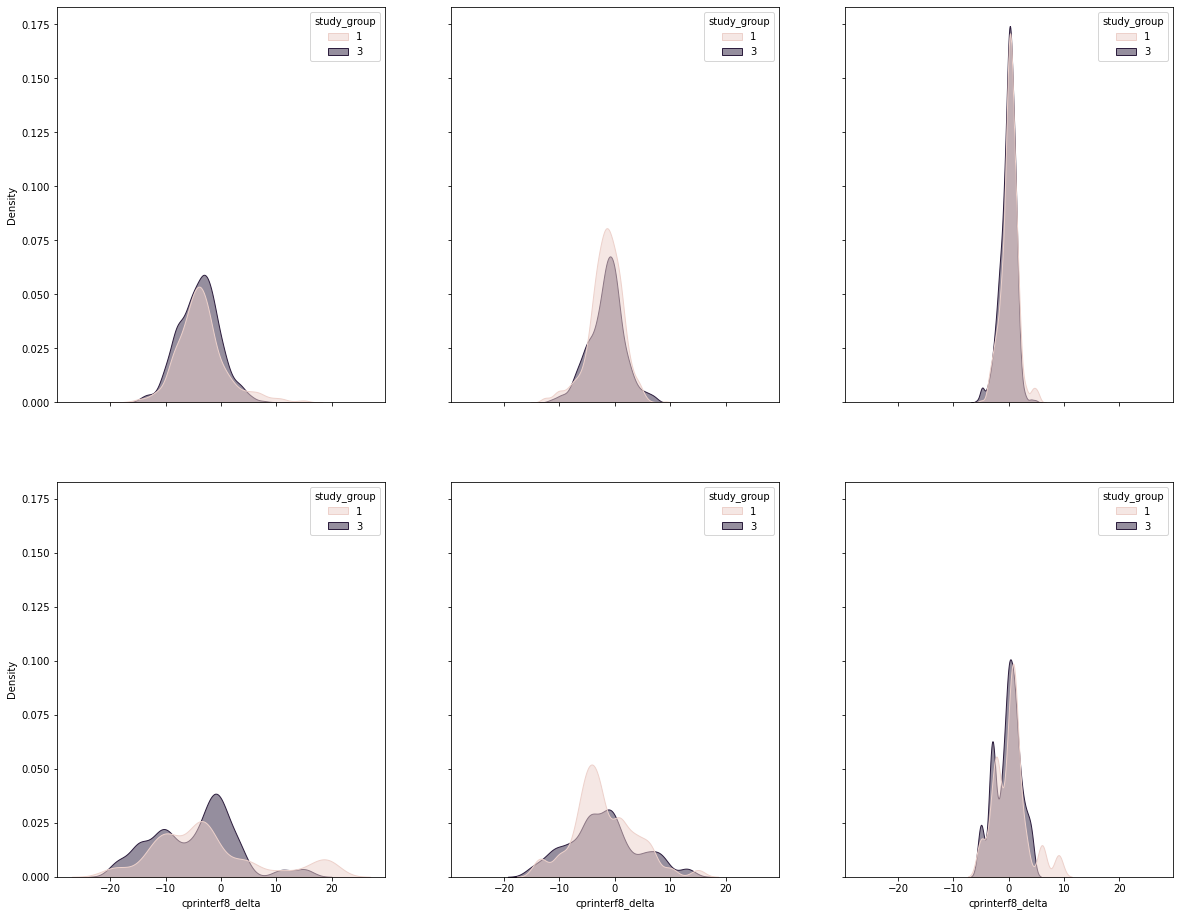

In [ ]:
### Predictions - Treatment (study group) by FAP Subgroup
# rcParams['figure.figsize'] = 15, 8
fig, ax = plt.subplots(nrows = 2, ncols=3, sharex=True, sharey=True, figsize=(20,16))

# HPD
sns.kdeplot(
    data=predictions.loc[predictions.cluster2019_base==1],
    x='prediction',
    shade=True,
    alpha=.5,
    hue = 'study_group',
    ax = ax[0, 0]
);

fig = sns.kdeplot(
    data = predictions.loc[predictions.cluster2019_base==1],
    x = outcome_var,
    shade = True,
    alpha = .5,
    hue = 'study_group',
    ax = ax[1, 0]
);

# HPA
sns.kdeplot(
    data=predictions.loc[predictions.cluster2019_base==2],
    x='prediction',
    shade=True,
    alpha=.5,
    hue = 'study_group',
    ax = ax[0, 1]
);
fig = sns.kdeplot(
    data = predictions.loc[predictions.cluster2019_base==2],
    x = outcome_var,
    shade = True,
    alpha = .5,
    hue = 'study_group',
    ax = ax[1, 1]
);


# LPA
fig = sns.kdeplot(
    data=predictions.loc[predictions.cluster2019_base==3],
    x='prediction',
    shade=True,
    alpha=.5,
    hue = 'study_group',
    ax = ax[0, 2]
    # common_norm = True
);
fig = sns.kdeplot(
    data = predictions.loc[predictions.cluster2019_base==3],
    x = outcome_var,
    shade = True,
    alpha = .5,
    hue = 'study_group',
    ax = ax[1, 2]
);


# plt.xlabel("Prediction - CSI GI Impact");

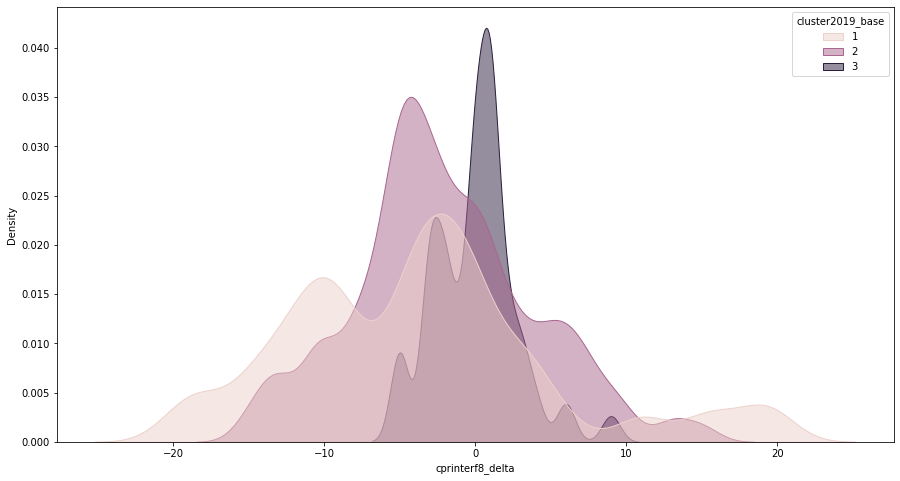

In [ ]:
### Actual Delta - Treatment (study group) by FAP Subgroup
fig = sns.kdeplot(
    data=predictions,
    x= outcome_var,
    shade=True,
    alpha=.5,
    hue = 'cluster2019_base',
    # common_norm = True
);

# plt.savefig('api_delta_actual')

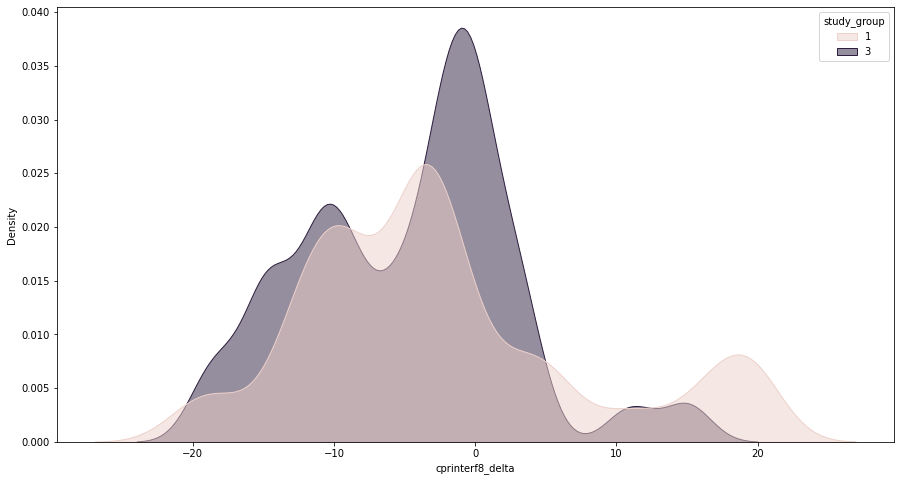

In [ ]:
### Actual Delta - Treatment (study group) by FAP Subgroup
fig = sns.kdeplot(
    data=predictions.loc[predictions.cluster2019_base==1],
    x = outcome_var,
    shade=True,
    alpha=.5,
    hue = 'study_group',
    # common_norm = True
);

# plt.xlabel("Prediction - CSI GI Impact");
# plt.savefig('api_delta_actual')

### Feature Importance
---

In [ ]:
## FEATURE IMPORTANCE
# ---------------------------
# X_data_scaled or X_data_subset

# cols = X_data_subset.columns.values
# cols = X_data.columns.values
# cols = X_data_subset_20.columns.values
# cols = X_data_subset_15.columns.values
# cols = X_data_subset_top.columns.values

feature_import = [x[0].feature_importances_ for x in model_store]

df_feature_import = pd.DataFrame(
    columns = cols,
    data = feature_import)

ValueError: ignored

In [ ]:
# TOP X ON AVERAGE
# ---------------------------
df_feature_import.mean().sort_values(ascending = False)[:15]

In [ ]:
# TOP X - BEST MODEL
# ---------------------------

# get index with lowest error
best_idx = model_results['overall']['mae'].index(min(model_results['overall']['mae']))

df_feature_import.iloc[best_idx].sort_values(ascending = False)[:15]

prsleep3_txfap       0.205371
fdi12_txfap          0.162853
promis_anx5_txfap    0.158968
pbq9_txfap           0.104029
fdi8_txfap           0.077124
pbq3_txfap           0.063996
pbq10_txfap          0.048012
cdi9_txfap           0.045107
pcsc12_txfap         0.031201
study_group          0.024020
csi3_txfap           0.019582
csi1_txfap           0.017093
pbq1_txfap           0.016077
cdi10_txfap          0.012046
prsleep4_txfap       0.005955
Name: 41, dtype: float64

### Best Model Params
---

In [ ]:
model_store[best_idx]

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.20000000000000004,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
# Best Model Performance - Average Error by Combination
# ---------------------------
# n = 50, 184 records
predictions_best_model = predictions[(best_idx*184):((best_idx+1)*184)]


predictions_best_model[['cluster2019_base', 'mae']]\
  .groupby(['cluster2019_base'])\
  .mean()\
  .reset_index()

,cluster2019_base,mae
0,1,4.564667
1,2,3.859434
2,3,1.735853


In [ ]:
# Export as dot file
from sklearn.tree import export_graphviz

export_graphviz(
    model_store[best_idx].estimators_[10], 
    out_file='tree.dot', 
    feature_names = X_data.columns.values,
    rounded = True, proportion = False, 
    precision = 2, filled = True);

plt.figure(figsize=(6,6));

In [ ]:
# Display in jupyter notebook
from subprocess import call
from IPython.display import Image

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600']);
Image(filename = 'tree.png');